In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
from signal_alignment import phase_align, chisqr_align

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

In [31]:
# Signal Processing

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

### Reading, Cleaning, and Preprocessing DATA

In [4]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'TNG_PROTRUSION', 'TNG_LAT', 'TNG_NOSE']
Conditions = ['FAST', 'SLOW', 'DISOR', 'HOLD']

TASK_DFS_VIDEO_LIST = list()
TASK_DFS_WAVE_LIST = list()

In [5]:
# choose a task to do the analysis on,for example open, spread, pa, bbp, etc
Task = Tasks[1]

In [6]:
#####   WAVE DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_w = r'C:\Users\jafarid\Documents\Code\ValidationStudy\RM_3_20191101\WAVE\RM_3_20191101'
ext_w=('.tsv')
Files_w = os.listdir(path_w)           
Files_w = [i for i in Files_w if i.endswith(ext_w)]

for i in range(0, len(Files_w)):
    # choose which task to focus on 
    if Task in Files_w[i]:
        df = pd.read_csv(path_w+ "\\" + Files_w[i], delimiter='\t', skiprows=1,header=None)
        df = cleaning_wave_df(df)
        # depending on the file we are reading the indexing below needs to change 
        if Files_w[i][20:-4] == 'EN_HOLD_1' or Files_w[i][20:-4] == 'EN_HOLD':
            df['FileName'] = Files_w[i][18:-4]
        
        else: 
            df['FileName'] = Files_w[i][20:-4]
        df['PatientID'] = Files_w[i][:4]
        df['DataDATE'] = Files_w[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_w[i]:
                df['Condition'] = condition

            if 'Condition' not in df.columns:
                df['Condition'] = 'NORMAL'
                
   
        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                       df[["X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Left'] = np.array(left_area)
        right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                        df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Right'] =  np.array(right_area)        
        df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=7)
        df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=7)
        df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion'], df["Time"]), 3)
        TASK_DFS_WAVE_LIST.append(df)
        
 
        print(Files_w[i][18:-4])

    


OPEN_HOLD
OPEN_HOLD_1
1_OPEN
1_OPEN_1
2_OPEN_DISOR
3_OPEN_DISOR_1
4_OPEN_FAST
5_OPEN_FAST_1


In [7]:
#####   VIDEO DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\FacialTrackingProcessed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    # choose which task to focus on 
    if Task in Files_v[i]:
        df = pd.read_csv(path_v+ "\\" + Files_v[i])
        df =  df.drop([0]) 
        df = cleaning_video_df(df)
        # depending on the file we are reading the indexing below needs to change 
        df['FileName'] = Files_v[i][12:-16]
        df['PatientID'] = Files_v[i][:4]
        df['DataDATE'] = Files_v[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_v[i]:
                df['Condition'] = condition

            if 'Condition' not in df.columns:
                df['Condition'] = 'NORMAL'
                

        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                       df[["X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Left'] = np.array(left_area)
        right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                        df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Right'] =  np.array(right_area)        
        df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion_F1'], df["Time"]), 3)
        TASK_DFS_VIDEO_LIST.append(df)
        print(Files_v[i][12:-16])

    


OPEN_1
OPEN_DISOR_1
OPEN_DISOR
OPEN_FAST_1
OPEN_FAST
OPEN_HOLD_1
OPEN_HOLD
OPEN


In [17]:
if 0:
    WAVE_30HZ = pd.DataFrame()
    WAVE_30HZ['Vert_Lip_Motion'] = signal.resample_poly(DF_WAVE['Vert_Lip_Motion'], 3, 10, axis=0)
    WAVE_30HZ['Time'] =signal.resample_poly(DF_WAVE['Time'], 3, 10, axis=0)
    WAVE_30HZ['Speed'] =signal.resample_poly(DF_WAVE['Speed'], 3, 10, axis=0)
    

In [78]:
# downsampling to 30 Hz for the wave data

TASK_DFS_WAVE_100HZ_LIST = list()
for DF_WAVE in TASK_DFS_WAVE_LIST:
    WAVE_100HZ = pd.DataFrame()
    WAVE_100HZ['Vert_Lip_Motion'] = signal.resample_poly(DF_WAVE['Vert_Lip_Motion_F1'], 10, 10, axis=0)
    WAVE_100HZ['Time'] =signal.resample_poly(DF_WAVE['Time'], 10, 10, axis=0)
    WAVE_100HZ['Speed'] =signal.resample_poly(DF_WAVE['Speed_F1'], 10, 10, axis=0)
    WAVE_100HZ['FileName'] = DF_WAVE['FileName'][1]
    TASK_DFS_WAVE_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_WAVE['Vert_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Vert_Lip_Motion']))
    #print()

2511
2511

2368
2368

1545
1545

1770
1770

1943
1943

1745
1745

1177
1177

1004
1004



In [19]:
TASK_DFS_VIDEO_100HZ_LIST = list()

In [20]:
# Upsampling to 100Hz for the video data

for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    VIDEO_100HZ = pd.DataFrame()
    VIDEO_100HZ['Vert_Lip_Motion'] = signal.resample_poly(DF_VIDEO['Vert_Lip_Motion_F1'], 10,3, axis=0)
    VIDEO_100HZ['Time'] =signal.resample_poly(DF_VIDEO['Time'], 10,3, axis=0)
    VIDEO_100HZ['Speed'] =signal.resample_poly(DF_VIDEO['Speed_F1'], 10, 3, axis=0)
    VIDEO_100HZ['FileName'] = DF_VIDEO['FileName'][1]
    TASK_DFS_VIDEO_100HZ_LIST.append(VIDEO_100HZ)
    
    

In [60]:
# read the matlab data and compare the two sampling frequencies 
matlabData = pd.read_csv('VideoOpen1')
for DF_VIDEO in TASK_DFS_VIDEO_100HZ_LIST:
    if  DF_VIDEO['FileName'][1] == 'OPEN_1':
    #print(DF_VIDEO['FileName'][1])
        video_data = DF_VIDEO['Vert_Lip_Motion'].values

In [61]:
matlabData_F1 = gaussian_filter(matlabData, sigma=7)

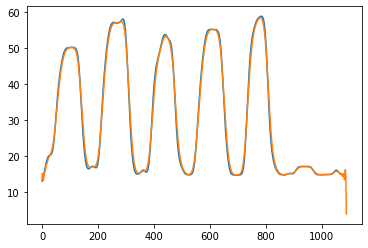

In [62]:
plt.plot(matlabData_F1)
plt.plot(video_data)

In [24]:
# perform the spline function on the wave data, create spline model using the time and data, then feed in the ideal time and 
# interpolate/extrapolate 


In [25]:
TASK_DFS_WAVE_LIST[0].head()

,Time,FrameID,SensorID,Sensor_1Status,X_Nose,Y_Nose,Z_Nose,SensorID,Sensor_2Status,X_LLeft,...,Task,Condition,Horiz_Lip_Motion,Vert_Lip_Motion,Area_Left,Area_Right,Area_Ratio,Vert_Lip_Motion_F1,Horiz_Lip_Motion_F1,Speed_F1
0,0.0347,0,0,55,-35.134182,-42.111202,-151.57620,2,55,-70.819328,...,OPEN,HOLD,66.211464,17.674076,309.896400,313.921508,0.987178,17.684643,66.251380,0.013700
1,0.0447,1,0,55,-35.171501,-42.129330,-151.57527,2,55,-70.853836,...,OPEN,HOLD,66.246809,17.685554,310.177036,314.292785,0.986905,17.685310,66.251101,0.043749
2,0.0547,2,0,55,-35.186321,-42.132694,-151.57590,2,55,-70.869865,...,OPEN,HOLD,66.257287,17.670842,310.283962,313.870369,0.988574,17.686628,66.250539,0.111204
3,0.0647,3,0,55,-35.206268,-42.150124,-151.58449,2,55,-70.851318,...,OPEN,HOLD,66.270903,17.653412,310.312073,313.256282,0.990601,17.688565,66.249687,0.221658
4,0.0747,4,0,55,-35.231308,-42.174553,-151.60271,2,55,-70.897232,...,OPEN,HOLD,66.254232,17.647919,310.286837,312.781330,0.992025,17.691071,66.248542,0.368893


In [26]:
path = r'C:\Users\jafarid\Documents\Code\ValidationStudy\MatlabData'

for DF_WAVE in TASK_DFS_WAVE_LIST:
    out = pd.DataFrame()

    out['Time'] = DF_WAVE['Time'].values
    out['Vert_Lip_Motion'] = DF_WAVE['Vert_Lip_Motion'].values
    out['Speed_F1'] = DF_WAVE['Speed_F1'].values
    out['Area_Left'] = DF_WAVE['Area_Left'].values
    out['Area_Right'] = DF_WAVE['Area_Right'].values
    
    cvs = path + 'Wave' + DF_WAVE['FileName'][1]+'_MatlabResults.csv'
    out.to_csv(cvs)

In [27]:
for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    out = pd.DataFrame()

    out['Time'] = DF_VIDEO['Time'].values
    out['Vert_Lip_Motion'] = DF_VIDEO['Vert_Lip_Motion'].values
    out['Speed_F1'] = DF_VIDEO['Speed_F1'].values
    out['Area_Left'] = DF_VIDEO['Area_Left'].values
    out['Area_Right'] = DF_VIDEO['Area_Right'].values
    
    cvs = path + 'Video' + DF_VIDEO['FileName'][1]+'_MatlabResults.csv'
    out.to_csv(cvs)

OPEN_HOLD
Wave index:0
Video index:6
The phase shift is:129.29
OPEN_HOLD_1
Wave index:1
Video index:5
The phase shift is:148.27
OPEN
Wave index:2
Video index:7
The phase shift is:241.69
OPEN_1
Wave index:3
Video index:0
The phase shift is:594.04
OPEN_DISOR
Wave index:4
Video index:2
The phase shift is:452.27
OPEN_DISOR_1
Wave index:5
Video index:1
The phase shift is:452.33
OPEN_FAST
Wave index:6
Video index:4


C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

The phase shift is:69.22
OPEN_FAST_1
Wave index:7
Video index:3
The phase shift is:402.63


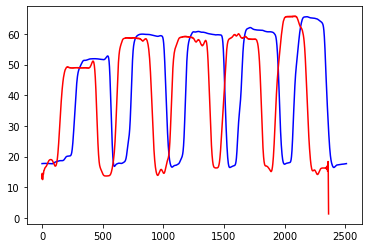

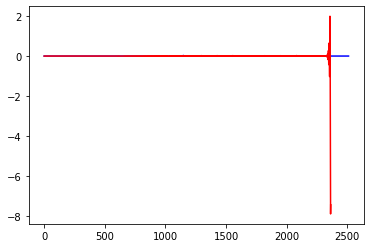

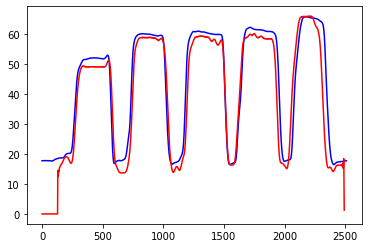

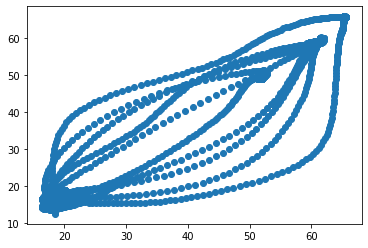

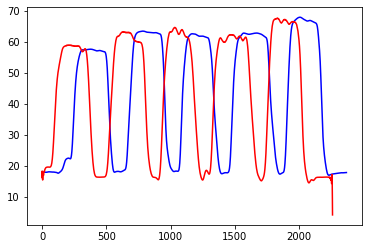

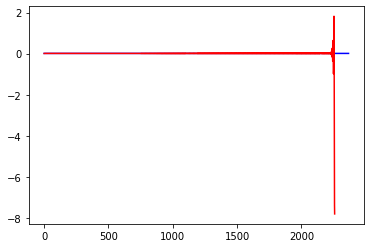

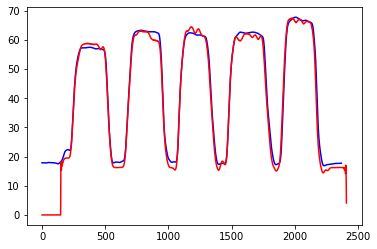

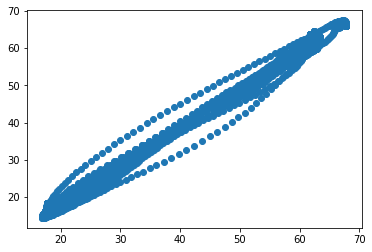

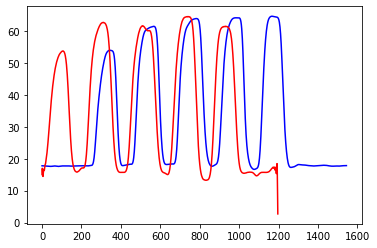

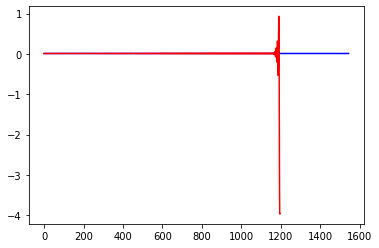

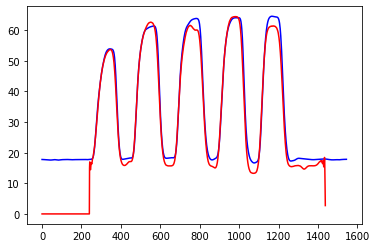

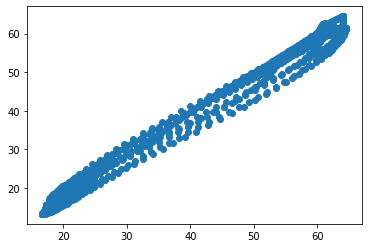

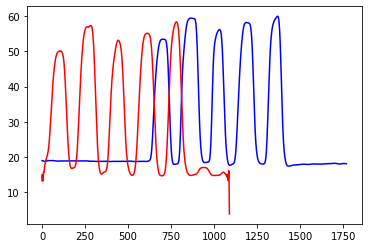

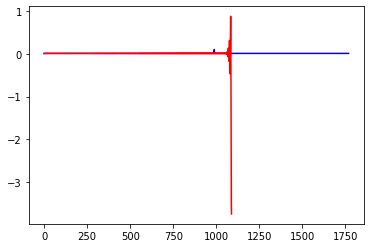

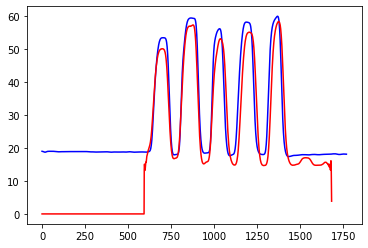

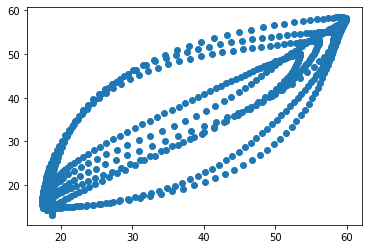

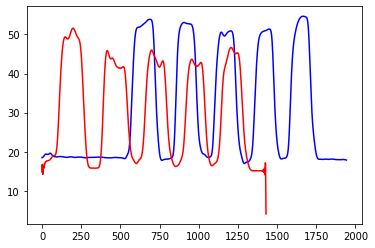

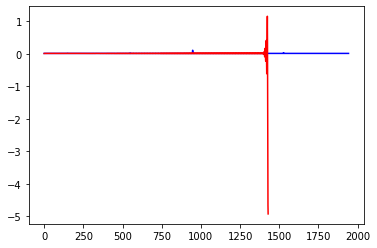

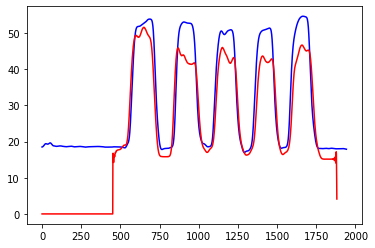

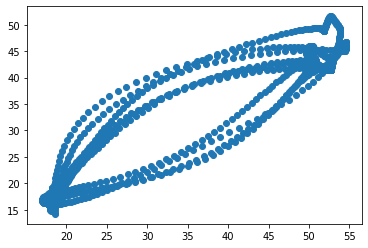

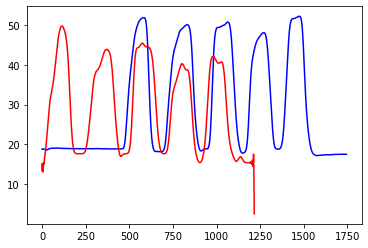

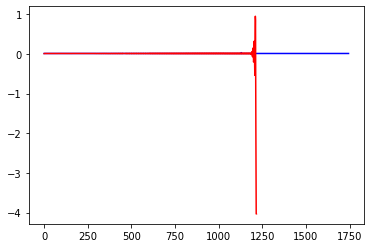

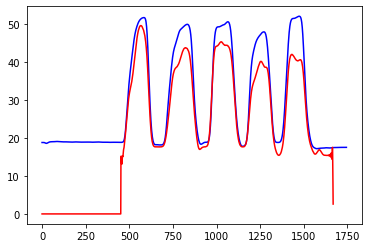

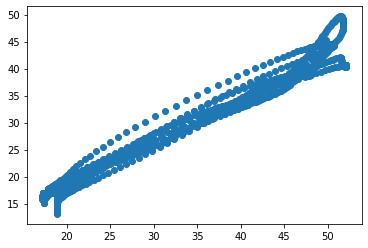

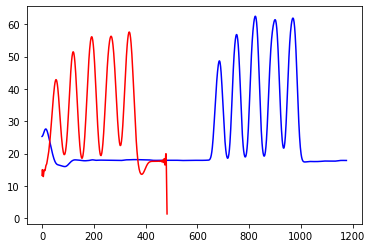

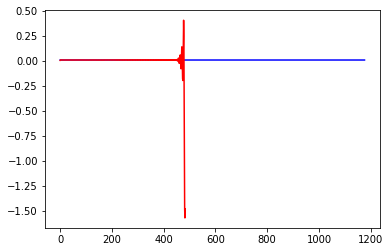

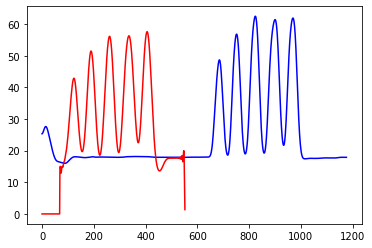

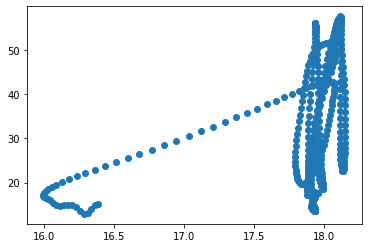

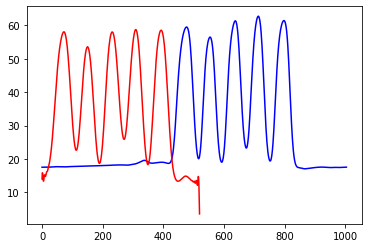

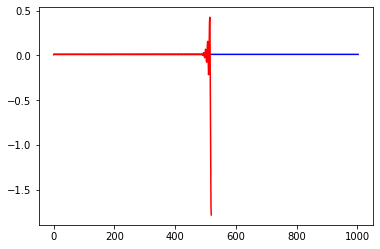

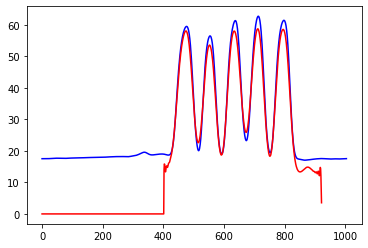

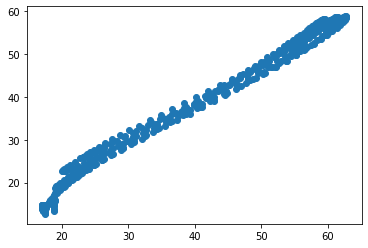

In [80]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
        if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
            print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
            print('Wave index:{}'.format(i))
            print('Video index:{}'.format(j))
            
            video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'])
            wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'])
            
            upper_bound = len(video_n) - 10
            
            s = phase_align(wave_n, video_n, [5,upper_bound])
            print('The phase shift is:{}'.format(s))
            
            sp = math.ceil(s)
            
            
            video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],sp)
            
            if len(video_shifted) <= len(wave_n):
                signal_bound = upper_bound + sp
            else: 
                signal_bound = len(wave_n) - 10 
           
            print()
            plt.figure()
            
            plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'],'b')
            plt.plot(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],'r')
            
            plt.figure()
            a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[i]['Time'])
            plt.plot(a, 'b')
            b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[j]['Time'])
            plt.plot(b, 'r')
            
            plt.figure()
            plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'],'b')
            plt.plot(video_shifted,'r')
            
            plt.figure()
            plt.scatter(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'][sp:signal_bound], 
                        video_shifted[sp:signal_bound])

    

OPEN_HOLD
2364
2511
126.9
127
2490


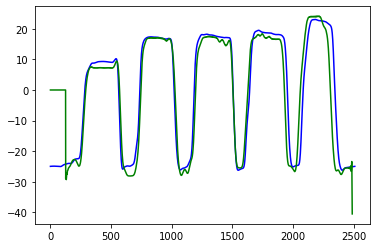

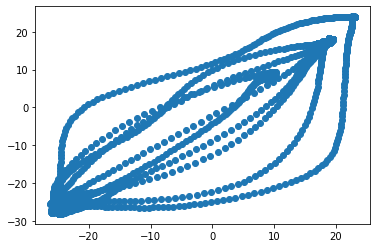

In [53]:
# WRONG PLOTS NEED TO BE FIXED FOR NORMALIZATION 

print('OPEN_HOLD')
wave = TASK_DFS_WAVE_LIST[2]['Vert_Lip_Motion_F1']
video = TASK_DFS_VIDEO_100HZ_LIST[7]['Vert_Lip_Motion']
print(len(video_n))
print(len(wave_n))
s = phase_align(wave_n, video_n, [10,2300])
print(s)
sp = math.ceil(s)
print(sp)
video_shifted = sig_shift(video_n,sp)


print(len(video_shifted))
plt.figure()
plt.plot(wave_n,'b')
#plt.plot(video,'r')
plt.plot(video_shifted, 'g')
plt.figure()
plt.scatter(wave_n[200:2400], video_shifted[200:2400])



The phase shift is:30.560000000000002



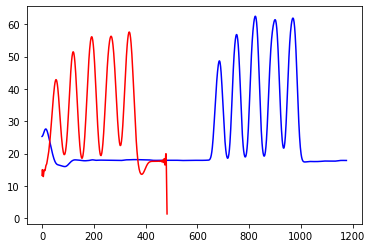

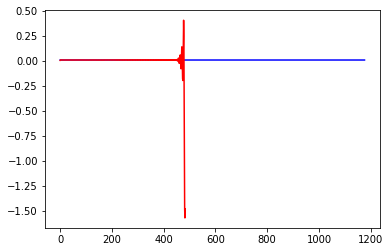

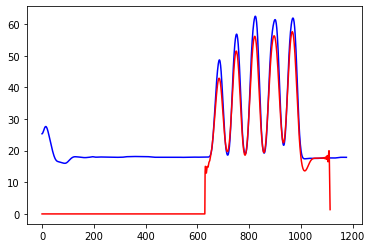

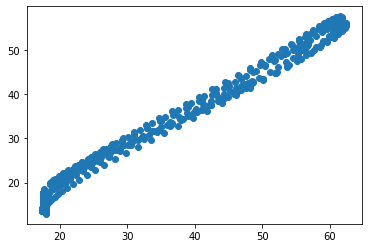

In [88]:
video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'])
wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'])

upper_bound = len(video_n) - 10
upper_bound2 = len(wave_n) - 10

s = phase_align(wave_n[600:1100], video_n, [10,upper_bound])
print('The phase shift is:{}'.format(s))

sp = math.ceil(s) + 600


video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],sp)

if len(video_shifted) <= len(wave_n):
    signal_bound = upper_bound + sp
else: 
    signal_bound = len(wave_n) - 10 

print()
plt.figure()

plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],'r')

plt.figure()
a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[6]['Time'])
plt.plot(a, 'b')
b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[4]['Time'])
plt.plot(b, 'r')

plt.figure()
plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(video_shifted,'r')

plt.figure()
plt.scatter(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'][sp:signal_bound], 
            video_shifted[sp:signal_bound])


2364
1123


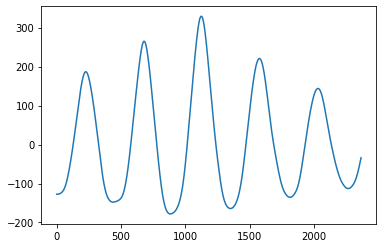

In [32]:
video_n = sig_norm(video)
wave_n = sig_norm(wave)

cross_corr_2 = correlate(video_n,wave_n,mode= 'same', method = 'direct') / len(video_n)
print(len(cross_corr_2))
print(np.argmax(cross_corr_2))

plt.plot(cross_corr_2)

In [35]:
c = chisqr_align(wave_n, video_n, [10,2000], init=-3.5,bound=2)

2364
2511


In [36]:
print(s)

122.15


In [33]:
plt.scatter(wave[20:700], video_shifted[20:700])

NameError: name 'video_shifted' is not defined

In [ ]:
len(video)

In [ ]:
print('OPEN')
print(len(TASK_DFS_WAVE_30HZ_LIST[2]))
print(len(TASK_DFS_VIDEO_LIST[7]))
wave = TASK_DFS_WAVE_30HZ_LIST[2]['Vert_Lip_Motion']
video = TASK_DFS_VIDEO_LIST[7]['Vert_Lip_Motion_F1']

video_shifted = sig_shift(video,76)

plt.figure()
plt.plot(wave,'b')
plt.plot(video,'black')
plt.figure()
plt.plot(wave,'b')
plt.plot(video_shifted, 'black')

# for our purposes rolling is not the fuction to use to shift the signal 
# video_rolled = np.roll(video, shift = 60)
#plt.figure()
#plt.plot(wave,'b')
#plt.plot(video_rolled, 'black')

In [ ]:
plt.scatter(wave[100:300], video_shifted[100:300])

In [ ]:
if 0:
    for i in range(len(TASK_DFS_WAVE_30HZ_LIST)):
        for j in range(len(TASK_DFS_VIDEO_LIST)):
            if TASK_DFS_WAVE_30HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_LIST[j]['FileName'][1]:
                print(TASK_DFS_WAVE_30HZ_LIST[i]['FileName'][1])
                nsamples = min(len(TASK_DFS_VIDEO_LIST[j]), len(TASK_DFS_WAVE_30HZ_LIST[i]))
                tmax = TASK_DFS_VIDEO_LIST[j]['Time'][nsamples]
                cross_corr = correlate(TASK_DFS_VIDEO_LIST[j],TASK_DFS_WAVE_30HZ_LIST[i] ,mode= 'full', method = 'direct')
                dt = numpy.linspace(-tmax,tmax, 2*nsamples-1)
                recovered_time_shift = dt[cross_corr.argmax()]
                print('The neeeded shift is:{}'.format(recovered_time_shift))



In [ ]:
print('OPEN')
wave = TASK_DFS_WAVE_30HZ_LIST[2]['Vert_Lip_Motion']
wave_mean = np.mean(wave)
wave_normalised = wave - wave_mean
wave_time = TASK_DFS_WAVE_30HZ_LIST[2]['Time']

video = TASK_DFS_VIDEO_LIST[7]['Vert_Lip_Motion_F1']
video_mean = np.mean(video)
video_normalised = video - video_mean
video_time = TASK_DFS_VIDEO_LIST[7]['Time']
cross_corr = correlate(video_normalised,wave_normalised, mode= 'full', method = 'direct')
#cross_corr

In [ ]:
print(len(wave))
print(len(video))

print(len(cross_corr))
print(np.argmax(cross_corr))
plt.plot(cross_corr)

In [ ]:
cross_corr_2 = correlate(video_normalised,wave_normalised,mode= 'same', method = 'direct') / len(video_normalised)
print(len(cross_corr_2))
print(np.argmax(cross_corr_2))

plt.plot(cross_corr_2)

In [ ]:
video_shifted = sig_shift(video,79)
video_shifted_1 = sig_shift(video,80)
video_shifted_2 = sig_shift(video,76)

plt.figure()
plt.plot(wave,'b')
plt.plot(video_shifted_2,'black')

plt.figure()
plt.plot(wave,'b')
plt.plot(video_shifted_1,'black')
plt.figure()
plt.plot(wave,'b')
plt.plot(video_shifted, 'red')

In [ ]:
159/2

In [ ]:
print('OPEN')

video_shifted = video.shift(74)

plt.plot(wave,'b')
plt.plot(video,'r')
plt.plot(video_shifted, 'g')

In [ ]:
plt.scatter(wave[100:300], video_shifted_1[100:300])

In [ ]:
#print(len(Vert_VD_30HZ))
#print(len( Vert_T_30HZ))

In [ ]:
#WAVE_30HZ.head()

In [ ]:
#WAVE_30HZ.plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='o')

In [ ]:
#DF_WAVE.Time.head()

In [ ]:
a = DF_VIDEO['Vert_Lip_Motion']
b = a.shift(80)
plt.plot(b)

In [ ]:
a = WAVE_30HZ['Vert_Lip_Motion']
b = a.shift(-40)
plt.plot(b,'r')


plt.plot(DF_VIDEO['Vert_Lip_Motion'],'b')
#plt.plot(WAVE_30HZ['Time'][80:],WAVE_30HZ['Vert_Lip_Motion'][80:])
plt.plot(WAVE_30HZ['Vert_Lip_Motion'], 'g')
#plt.plot(b)

In [ ]:
plt.scatter(b[20:600], DF_VIDEO['Vert_Lip_Motion'][20:600])
#plt.ylim(0,70)

In [ ]:
print(b)

In [ ]:
corr = signal.correlate(DF_VIDEO['Vert_Lip_Motion'], WAVE_30HZ['Vert_Lip_Motion'], mode='same')

In [ ]:
plt.plot(corr)

In [ ]:
DF_VIDEO.Time[640:650]


In [ ]:
DF_VIDEO.Time[2]- DF_VIDEO.Time[1]

In [ ]:
1/0.033399